<a href="https://colab.research.google.com/github/No1-JSPARK/ANN_Proejct_Proposal/blob/main/Improve_SEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/Solving English')

In [4]:
!pwd

/content/drive/MyDrive/Solving English


In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 36.3 MB/s 
     |████████████████████████████████| 182 kB 77.1 MB/s 
     |████████████████████████████████| 7.6 MB 62.3 MB/s 


In [6]:
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 31.7 MB/s 
     |████████████████████████████████| 1.3 MB 70.7 MB/s 
     |████████████████████████████████| 880 kB 66.9 MB/s 
     |████████████████████████████████| 132 kB 77.6 MB/s 
     |████████████████████████████████| 10.2 MB 43.5 MB/s 
     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 140 kB 57.8 MB/s 
     |████████████████████████████████| 127 kB 61.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=1c779c717a2b9a5a8687ddc115ddeabf106fab7a68314dd145f644e5475152c5
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstall

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
train_df = pd.read_csv('./dataset/proc_train.tsv', delimiter='\t')
valid_df = pd.read_csv('./dataset/proc_val.tsv', delimiter='\t')
test_df = pd.read_csv("./dataset/test_2.csv", encoding = 'cp1252')

In [10]:
train_df.head()

,context,label
0,This is the main motive for gossiping about we...,1
1,The chemical industry denied that there were p...,0
2,The ironic effect seems to be caused by the in...,1
3,The partner only has two options. He can take ...,0
4,An Egyptian sculpture no bigger than a person’...,1


In [11]:
valid_df.head()

,context,label
0,"In a sense, all competitions give feedback.",1
1,"Even under ideal circumstances, hunting these ...",1
2,"Among hunter-gatherers, animals are not only g...",1
3,But that’s not what happened.,1
4,"Consequently, any small difference in mental f...",1


In [12]:
test_df.head()

,context,label
0,Regulations covering scientific experiments on...,1
1,"Subjects must give their informed, written con...",1
2,"Scientists who experiment on themselves can, f...",1
3,They can also sidestep most of the ethical iss...,1
4,"Nonetheless, experimenting on oneself remains ...",1


In [13]:
class Datasets(Dataset):
  def __init__ (self, df):
    self.df = df
  
  def __len__ (self):
    return len(self.df)
  
  def __getitem__ (self, idx):
    text = self.df.iloc[idx,0]
    label = self.df.iloc[idx,1]
    return text, label

In [14]:
train_dataset = Datasets(train_df)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

In [15]:
valid_dataset = Datasets(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=0)

In [16]:
test_dataset = Datasets(test_df)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

100%|██████████| 440473133/440473133 [00:52<00:00, 8429940.60B/s] 


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
def save_checkpoint(save_path, model, valid_loss):
  if save_path == None:
    return
  state_dict = {'model_state_dict' : model.state_dict(), 'valid_loss' : valid_loss}
  torch.save(state_dict, save_path)
  ##print(f'Model save to ==> {save_path}')

In [26]:
def load_checkpoint(load_path, model):
  if load_path == None:
    return
  state_dict = torch.load(load_path, map_location=device)
  print(f'Model loaded from <== {load_path}')
  model.load_state_dict(state_dict['model_state_dict'])
  return state_dict['valid_loss']

In [27]:
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
  if save_path == None:
    return
  state_dict = {'train_loss_list' : train_loss_list,
                'valid_loss_list' : valid_loss_list,
                'global_steps_list' : global_steps_list}
  torch.save(state_dict, save_path)
  ##print(f'Model save to ==> {save_path}')

In [28]:
def load_metrics(load_path):
  if load_path == None:
    return
  state_dict = torch.load(load_path, map_location = device)
  print(f'Model loaded from <== {load_path}')
  return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [29]:
def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          num_epochs=5,
          eval_every=len(train_loader)//2,
          best_valid_loss=float("Inf")):
  
  total_correct = 0.0
  total_len = 0.0
  running_loss = 0.0
  valid_running_loss = 0.0
  global_step = 0
  train_loss_list = []
  valid_loss_list = []
  global_steps_list = []

  model.train()
  for epoch in range(num_epochs):
    for text, label in train_loader:
      optimizer.zero_grad()
      encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
      padded_list = [e + [0] * (512-len(e)) for e in encoded_list]
      sample = torch.tensor(padded_list)
      sample, label = sample.to(device), label.to(device)
      labels = torch.tensor(label)
      outputs = model(sample, labels=labels)
      loss, logits = outputs

      pred = torch.argmax(F.softmax(logits), dim=1)
      correct = pred.eq(labels)
      total_correct += correct.sum().item()
      total_len += len(labels)
      running_loss += loss.item()
      loss.backward()
      optimizer.step()
      global_step += 1

      if global_step % eval_every == 0:
        model.eval()
        with torch.no_grad():
          for text, label in valid_loader:
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list = [e + [0] * (512-len(e)) for e in encoded_list]
            sample = torch.tensor(padded_list)
            sample, label = sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            ouputs = model(sample, labels=labels)
            loss, logits = outputs
            valid_running_loss += loss.item()
        
        average_train_loss = running_loss / eval_every
        average_valid_loss = valid_running_loss / len(valid_loader)
        train_loss_list.append(average_train_loss)
        valid_loss_list.append(average_valid_loss)
        global_steps_list.append(global_step)

        running_loss = 0.0
        valid_running_loss = 0.0
        model.train()


        print('Epoch [{}/{}], Step[{}/{}], Train Loss : {:.4f}, Valid Loss : {:.4f}'.format(epoch+1, 
                                                                                            num_epochs, 
                                                                                            global_step, 
                                                                                            num_epochs*len(train_loader), 
                                                                                            average_train_loss, 
                                                                                            average_valid_loss))
        
        if best_valid_loss > average_valid_loss:
          best_valid_loss = average_valid_loss
          save_checkpoint('./dataset/model.pt', model, best_valid_loss)
          save_metrics('./dataset/metrics.pt', train_loss_list,
                       valid_loss_list, global_steps_list)
  save_metrics('./dataset/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

  print('훈련 종료!')

In [31]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer)

<ipython-input-29-fd5570383532>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)
<ipython-input-29-fd5570383532>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
<ipython-input-29-fd5570383532>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


Epoch [1/5], Step[45/450], Train Loss : 0.4867, Valid Loss : 0.1475
Epoch [1/5], Step[90/450], Train Loss : 0.5630, Valid Loss : 1.6577
Epoch [2/5], Step[135/450], Train Loss : 0.5139, Valid Loss : 1.0850
Epoch [2/5], Step[180/450], Train Loss : 0.4935, Valid Loss : 0.1963
Epoch [3/5], Step[225/450], Train Loss : 0.5086, Valid Loss : 0.1723
Epoch [3/5], Step[270/450], Train Loss : 0.5584, Valid Loss : 0.2512
Epoch [4/5], Step[315/450], Train Loss : 0.4230, Valid Loss : 0.1866
Epoch [4/5], Step[360/450], Train Loss : 0.6272, Valid Loss : 0.4996
Epoch [5/5], Step[405/450], Train Loss : 0.5468, Valid Loss : 0.8187
Epoch [5/5], Step[450/450], Train Loss : 0.5150, Valid Loss : 0.2268
훈련 종료!


Model loaded from <== ./dataset/metrics.pt


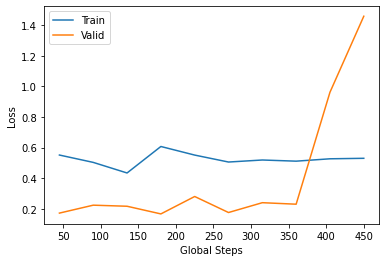

In [24]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('./dataset/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
def evaluate(model, test_loader):
  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for text, label in test_loader:
      encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
      padded_list = [e + [0] * (512-len(e)) for e in encoded_list]
      sample = torch.tensor(padded_list)
      sample, label = sample.to(device), label.to(device)
      labels = torch.tensor(label)
      output = model(sample, labels=labels)
      _, output = output
      y_pred.extend(torch.argmax(output, 1).tolist())
      y_true.extend(labels.tolist())
  
  print('Classification 결과:')
  print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

  cm = confusion_matrix(y_true, y_pred, labels=[1,0])
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.xaxis.set_ticklabels(['0', '1'])
  ax.yaxis.set_ticklabels(['0', '1'])


Model loaded from <== ./dataset/model.pt


<ipython-input-32-e3e74197ca51>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


Classification 결과:
              precision    recall  f1-score   support

           1     0.8529    1.0000    0.9206        29
           0     0.0000    0.0000    0.0000         5

    accuracy                         0.8529        34
   macro avg     0.4265    0.5000    0.4603        34
weighted avg     0.7275    0.8529    0.7852        34



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


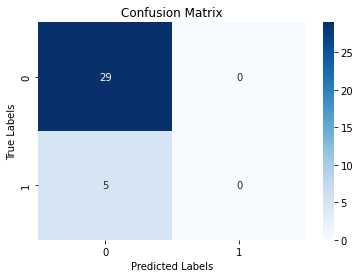

In [33]:
best_model = model.to(device)
load_checkpoint('./dataset/model.pt', best_model)
evaluate(best_model, test_loader)